# Part II: Exploratory Data Analysis (EDA)

## Basic settings

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os
import sys
import warnings
from datetime import datetime, timedelta

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 50
pd.options.display.max_columns = None

In [47]:
src_path = os.path.abspath(os.path.join("../..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)
from data_generator.data_generator import check_missing_values
from utils.plots import plot_custom_correlation, plot_top_items_by_units, plot_units_for_item, plot_units_by_store, plot_weather_trend, plot_rolling_mean_stationarity

In [48]:
DATA_DIR = "../../data/"
FIGURES_DIR = "../figures"

## Load preprocessed data

In [49]:
df_sales = pd.read_csv(
    os.path.join(DATA_DIR, "data_processed/sales_data_preprocessed.csv"), parse_dates=["date"]
)
df_weather = pd.read_csv(
    os.path.join(DATA_DIR, "data_processed/weather_preprocessed.csv"), parse_dates=["date"]
)

df_weather_key_store_merged = pd.read_csv(
    os.path.join(DATA_DIR, "data_processed/weather_key_store_merged.csv"), parse_dates=["date"]
)


In [50]:
df_sales = df_sales.sort_values(['store_nbr', 'item_nbr', 'date'])
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236038 entries, 0 to 236037
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            236038 non-null  datetime64[ns]
 1   store_nbr       236038 non-null  int64         
 2   item_nbr        236038 non-null  int64         
 3   units           236038 non-null  float64       
 4   logunits        236038 non-null  float64       
 5   is_kaggle_test  236038 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2)
memory usage: 9.2 MB


In [51]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46392 entries, 0 to 46391
Data columns (total 48 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station_nbr  46392 non-null  int64         
 1   date         46392 non-null  datetime64[ns]
 2   tmax         46392 non-null  float64       
 3   tmin         46392 non-null  float64       
 4   tavg         46392 non-null  float64       
 5   depart       46392 non-null  float64       
 6   dewpoint     46392 non-null  float64       
 7   wetbulb      46392 non-null  float64       
 8   heat         46392 non-null  float64       
 9   cool         46392 non-null  float64       
 10  sunrise      46392 non-null  float64       
 11  sunset       46392 non-null  float64       
 12  snowfall     46392 non-null  float64       
 13  preciptotal  46392 non-null  float64       
 14  stnpressure  46392 non-null  float64       
 15  sealevel     46392 non-null  float64       
 16  resu

In [52]:
df_weather

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,BCFG,BLDU,BLSN,BR,DU,DZ,FG,FG+,FU,FZDZ,FZFG,FZRA,GR,GS,HZ,MIFG,PL,PRFG,RA,SG,SN,SQ,TS,TSRA,TSSN,UP,VCFG,VCTS,store_nbr
0,1,2012-01-01,52.0,31.0,42.0,1.452913,36.0,40.0,23.0,0.0,585.011125,1823.365065,0.038126,0.05,29.78,29.92,3.6,20.0,4.6,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,2,2012-01-01,48.0,33.0,41.0,16.000000,37.0,39.0,24.0,0.0,716.000000,1626.000000,0.000000,0.07,28.82,29.91,9.1,23.0,11.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,16
2,3,2012-01-01,55.0,34.0,45.0,9.000000,24.0,36.0,20.0,0.0,735.000000,1720.000000,0.000000,0.00,29.77,30.47,9.9,31.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21
3,3,2012-01-01,55.0,34.0,45.0,9.000000,24.0,36.0,20.0,0.0,735.000000,1720.000000,0.000000,0.00,29.77,30.47,9.9,31.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29
4,3,2012-01-01,55.0,34.0,45.0,9.000000,24.0,36.0,20.0,0.0,735.000000,1720.000000,0.000000,0.00,29.77,30.47,9.9,31.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46387,17,2014-10-31,59.0,34.0,47.0,-3.333333,32.0,41.0,18.0,0.0,585.011125,1823.365065,0.000000,0.00,29.72,30.39,9.2,1.0,9.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,31
46388,17,2014-10-31,59.0,34.0,47.0,-3.333333,32.0,41.0,18.0,0.0,585.011125,1823.365065,0.000000,0.00,29.72,30.39,9.2,1.0,9.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,34
46389,18,2014-10-31,67.0,49.0,58.0,-4.000000,40.0,50.0,7.0,0.0,644.000000,1738.000000,0.000000,0.00,29.78,30.28,10.6,36.0,11.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36
46390,19,2014-10-31,45.0,33.0,39.0,-6.000000,24.0,32.0,26.0,0.0,624.000000,1646.000000,0.100000,0.02,29.51,30.24,20.4,34.0,20.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,30


## Perform EDA

In [53]:
print("=== BASIC STATISTICAL SUMMARY ===")

# 1. Thống kê mô tả Sales
print("\n--- df_sales Summary Statistics ---")
# Dataset này dùng 'units' thay vì 'sales'
if 'units' in df_sales.columns:
    print(df_sales["units"].describe())
elif 'sales' in df_sales.columns:
    print(df_sales["sales"].describe())
else:
    print("Target column (units/sales) not found.")

# 2. Thống kê mô tả Weather
print("\n--- df_weather Summary Statistics ---")
# Dataset này dùng 'tavg' (nhiệt độ TB) và 'dewpoint' (liên quan độ ẩm) thay vì 'temperature', 'humidity'
weather_cols_to_check = ['tavg', 'dewpoint', 'preciptotal']
existing_weather_cols = [c for c in weather_cols_to_check if c in df_weather.columns]
if existing_weather_cols:
    print(df_weather[existing_weather_cols].describe())
else:
    print("Weather columns not found.")

# 3. Kiểm tra khoảng thời gian
print("\n--- Date Range ---")
print(f"Sales Data:   {df_sales['date'].min()} to {df_sales['date'].max()}")
print(f"Weather Data: {df_weather['date'].min()} to {df_weather['date'].max()}")

# 4. Đếm giá trị duy nhất (Unique Values)
print("\n--- Unique Values ---")
# Chuyển store_id -> store_nbr, item_id -> item_nbr
store_col = 'store_nbr' if 'store_nbr' in df_sales.columns else 'store_id'
item_col = 'item_nbr' if 'item_nbr' in df_sales.columns else 'item_id'

print(f"Number of unique stores: {df_sales[store_col].nunique()}")
print(f"Number of unique items:  {df_sales[item_col].nunique()}")

=== BASIC STATISTICAL SUMMARY ===

--- df_sales Summary Statistics ---
count    236038.000000
mean         15.934398
std          27.437444
min           0.000000
25%           0.000000
50%           1.000000
75%          20.000000
max         137.000000
Name: units, dtype: float64

--- df_weather Summary Statistics ---
               tavg      dewpoint   preciptotal
count  46392.000000  46392.000000  46392.000000
mean      62.006483     47.133113      0.114475
std       18.349680     19.237105      0.343181
min      -16.000000    -24.000000      0.000000
25%       50.000000     32.000000      0.000000
50%       65.000000     51.000000      0.000000
75%       77.000000     64.000000      0.099809
max      100.000000     77.000000      7.360000

--- Date Range ---
Sales Data:   2012-01-01 00:00:00 to 2014-10-31 00:00:00
Weather Data: 2012-01-01 00:00:00 to 2014-10-31 00:00:00

--- Unique Values ---
Number of unique stores: 45
Number of unique items:  111


In [54]:
save_figrure = True

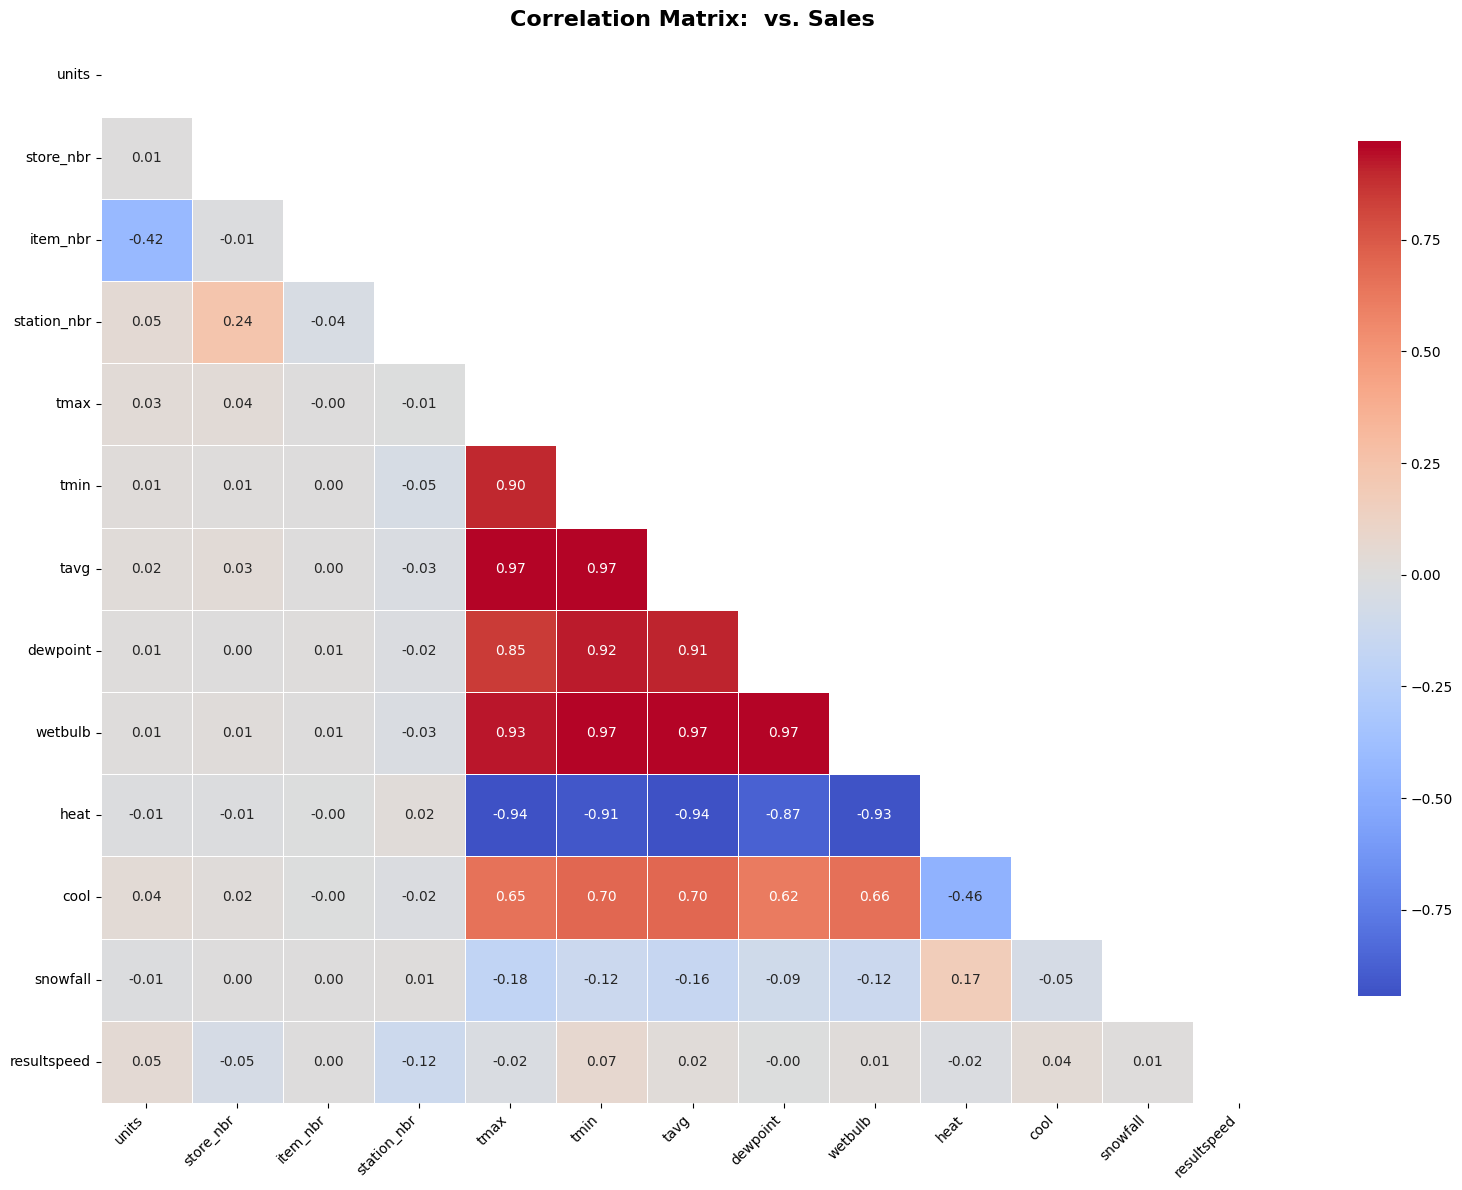


=== Top Correlation with Sales () ===
resultspeed    0.050595
cool           0.036226
tmax           0.032586
tavg           0.023040
tmin           0.013703
wetbulb        0.011536
dewpoint       0.006672
snowfall      -0.011672
heat          -0.013488
Name: units, dtype: float64


In [55]:
cols_of_interest = [
        "tmax",
        "tmin",
        "tavg",
        "dewpoint",
        "wetbulb",
        "heat",
        "cool",
        "precip_total",
        "snowfall",
        "resultspeed",  # Weather features
    ]

plot_custom_correlation(df_weather_key_store_merged, feature_cols = cols_of_interest)

1. Tương quan thấp giữa Weather và Units: Như bạn thấy trong Heatmap, các ô giao nhau giữa units và các biến thời tiết (tmax, tmin, tavg, dewpoint...) đều có màu trắng/xám rất nhạt, với giá trị gần bằng 0 (ví dụ 0.02, 0.01).​
- Điều này xác nhận: Thời tiết KHÔNG tác động trực tiếp theo kiểu tuyến tính đơn giản (nóng lên 1 độ -> bán thêm 10 cái).
- Nó tác động theo kiểu phi tuyến (Non-linear) hoặc gián tiếp (Threshold): Phải nóng ĐẾN MỘT MỨC NÀO ĐÓ (ví dụ > 35 độ) hoặc mưa RẤT TO thì doanh số mới sụt giảm hoặc tăng vọt. Các mô hình tuyến tính (Linear 1 Regression) sẽ thất bại ở đây, nhưng Tree-based models (XGBoost, LightGBM) sẽ bắt được các điểm gãy (split points) này rất tốt.

2. Đa cộng tuyến (Multicollinearity) cực mạnh:
- Cụm tmax, tmin, tavg, dewpoint, wetbulb, heat đỏ rực một góc (> 0.90).
- Đúng như bạn nói, chúng là "anh em sinh đôi". Đưa cả đám này vào mô hình là thừa thãi và gây hại.

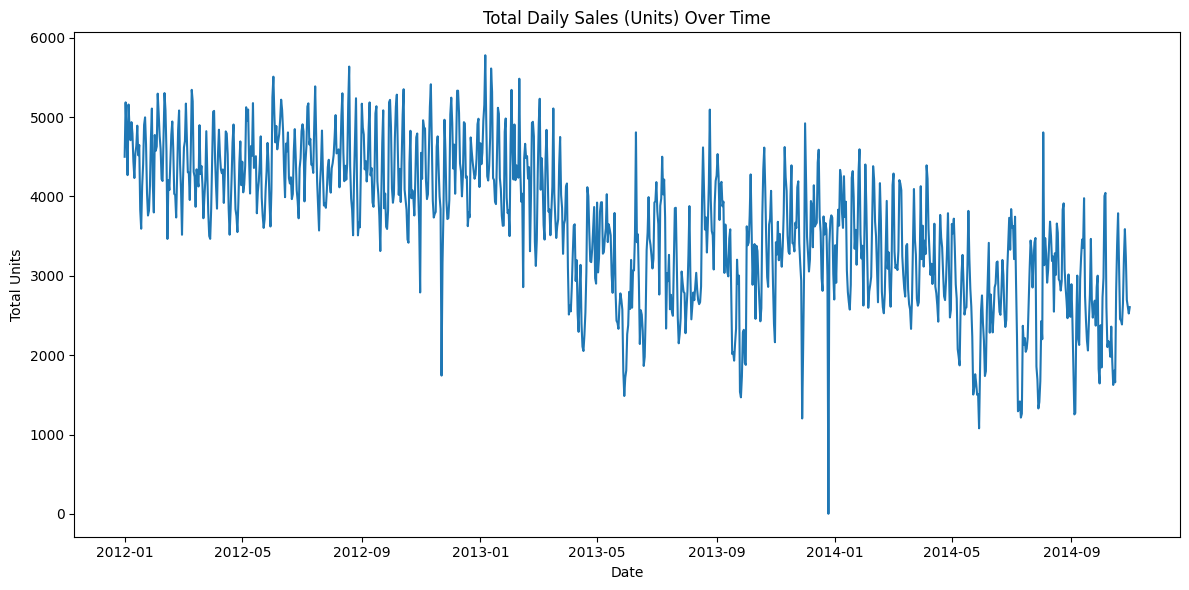

In [56]:
# df_sales trends over time
plt.figure(figsize=(12, 6))

# Chỉnh sửa: Dùng 'units' thay vì 'sales'
daily_df_sales = df_sales.groupby("date")["units"].sum().reset_index()

# Chỉnh sửa: Plot cột 'units'
plt.plot(daily_df_sales["date"], daily_df_sales["units"])

plt.title("Total Daily Sales (Units) Over Time")
plt.xlabel("Date")
plt.ylabel("Total Units") # Chỉnh label cho khớp
plt.tight_layout()

    
plt.show() # Thêm dòng này để hiển thị hình trong notebook


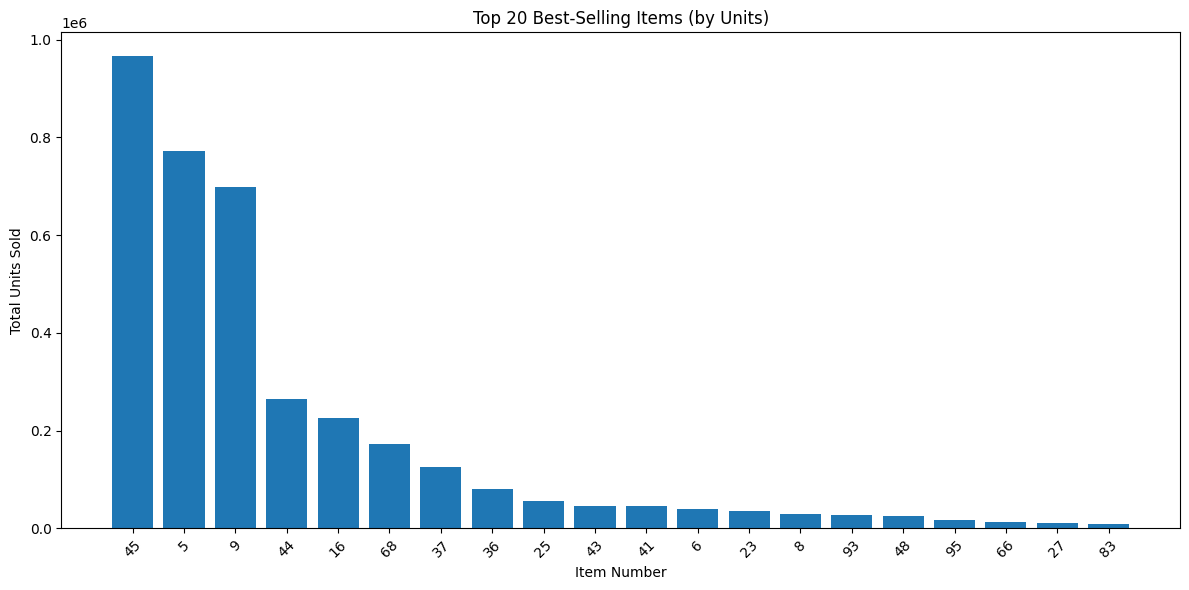

In [57]:
# Top 20 Best-Selling Items
plt.figure(figsize=(12, 6))

# Group theo item_nbr và tính tổng units, sau đó lấy Top 20
top_items = (
    df_sales.groupby("item_nbr")["units"]
    .sum()
    .sort_values(ascending=False)
    .head(20) # Chỉ lấy 20 sản phẩm bán chạy nhất
)

# Chuyển index (item_nbr) sang string để trục X không tự sắp xếp lại theo số
item_labels = top_items.index.astype(str)

plt.bar(item_labels, top_items.values)
plt.title("Top 20 Best-Selling Items (by Units)")
plt.xlabel("Item Number")
plt.ylabel("Total Units Sold")
plt.xticks(rotation=45)
plt.tight_layout()
    
plt.show()


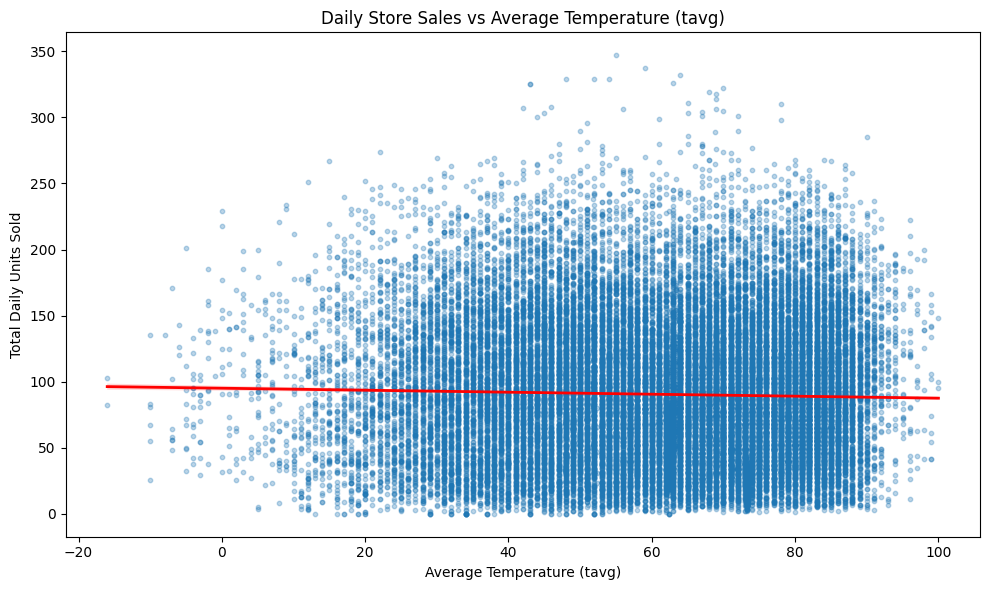

In [58]:
# Correlation between Temperature (tavg) and Sales (units)
plt.figure(figsize=(10, 6))

# 1. Chuẩn bị dữ liệu
# Lưu ý: Cần merge df_sales với df_weather trước. 
# Giả sử df_sales đã có sẵn cột 'tavg' (do bạn đã merge weather vào trước đó)
# Nếu chưa merge, đoạn code này sẽ fail. Code dưới giả định bạn ĐÃ merge.

if 'tavg' in df_weather_key_store_merged.columns:
    # Group by Date & Store để tính tổng sales mỗi ngày mỗi cửa hàng
    # (Vì nhiệt độ là theo ngày/store, không phải theo từng item)
    daily_store_sales = (
        df_weather_key_store_merged.groupby(['date', 'store_nbr'])
        .agg({'units': 'sum', 'tavg': 'mean'}) # Tổng units, Lấy tavg (nhiệt độ giống nhau cho cùng 1 store-date)
        .reset_index()
    )
    
    # Scatter plot with regression line
    sns.regplot(
        data=daily_store_sales,
        x="tavg",
        y="units",
        scatter_kws={"alpha": 0.3, "s": 10}, 
        line_kws={"color": "red", "linewidth": 2},
    )

    plt.title("Daily Store Sales vs Average Temperature (tavg)")
    plt.xlabel("Average Temperature (tavg)")
    plt.ylabel("Total Daily Units Sold")
    plt.tight_layout()

    plt.show()

else:
    print("Error: 'tavg' column not found in df_sales. Please merge weather data first.")


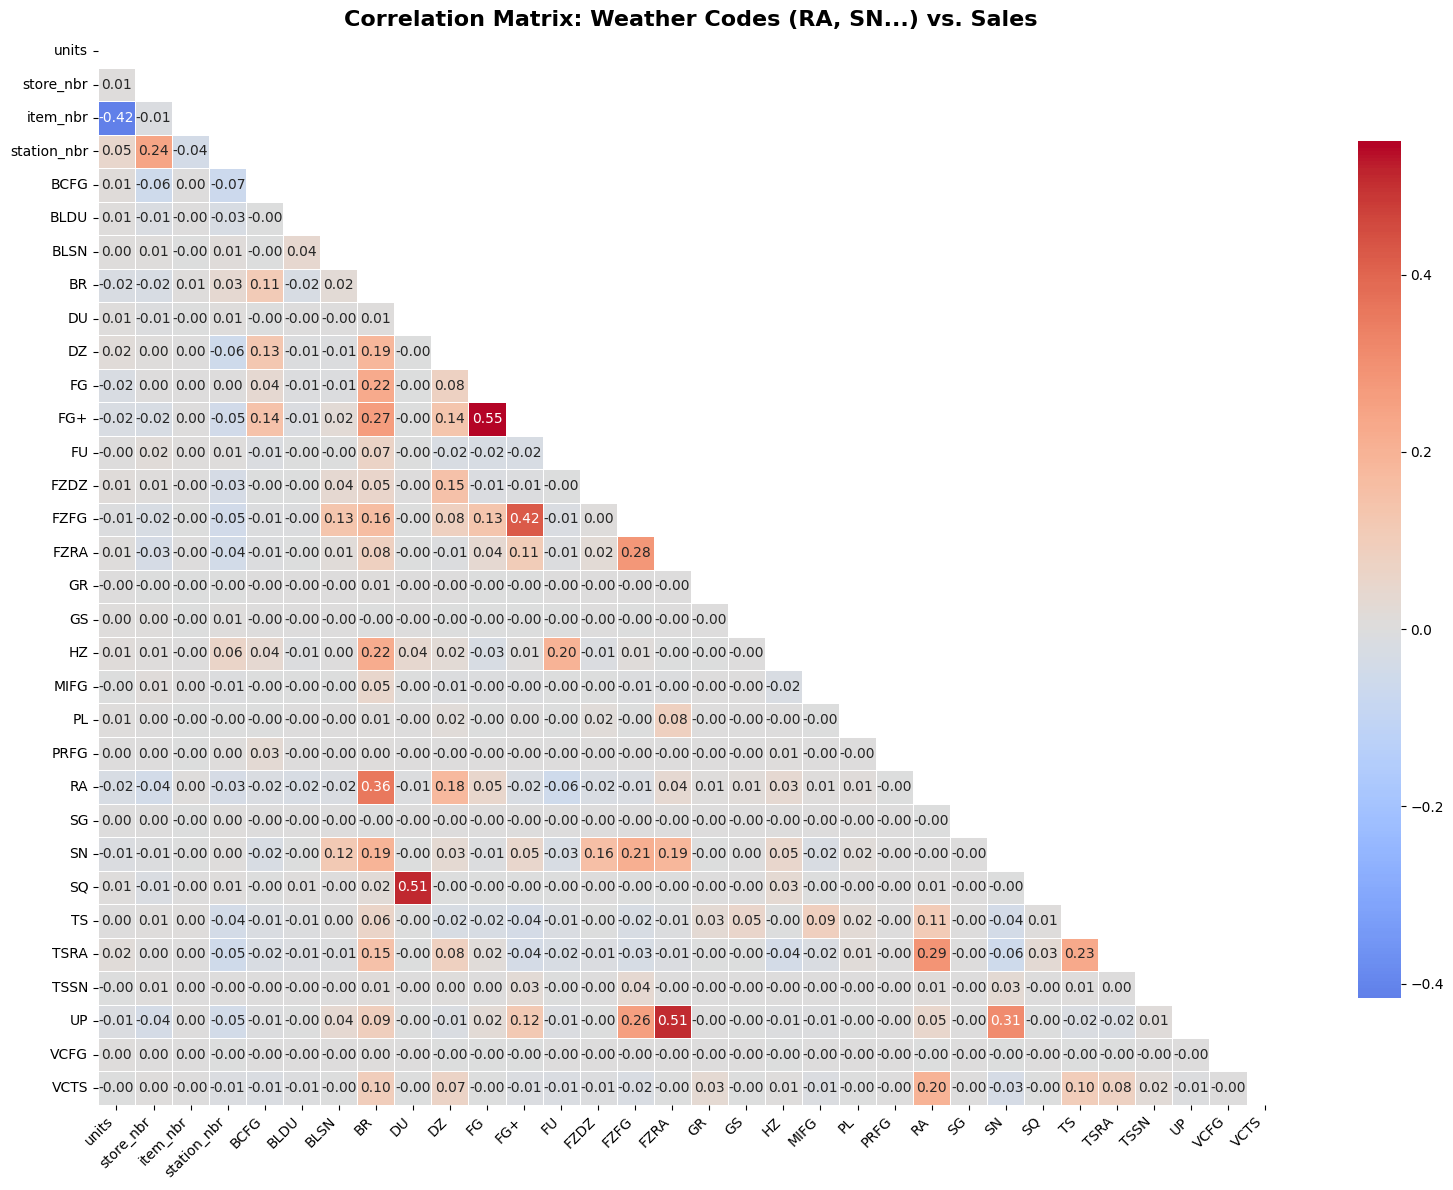


=== Top Correlation with Sales (Weather Codes (RA, SN...)) ===
TSRA    0.015625
DZ      0.015613
HZ      0.012869
BCFG    0.011930
FZDZ    0.011703
PL      0.010281
DU      0.006983
FZRA    0.006695
BLDU    0.006647
SQ      0.005795
BLSN    0.004231
VCFG    0.004099
GS      0.003692
TS      0.001806
PRFG    0.001173
SG      0.001135
GR     -0.000243
FU     -0.000702
TSSN   -0.001237
MIFG   -0.001818
VCTS   -0.002294
FZFG   -0.008409
UP     -0.009819
SN     -0.010451
FG+    -0.016572
BR     -0.017259
FG     -0.019078
RA     -0.020292
Name: units, dtype: float64


In [59]:
weather_code_cols = [
    'BCFG', 'BLDU', 'BLSN', 'BR', 'DU', 'DZ', 'FG', 'FG+', 
    'FU', 'FZDZ', 'FZFG', 'FZRA', 'GR', 'GS', 'HZ', 'MIFG', 
    'PL', 'PRFG', 'RA', 'SG', 'SN', 'SQ', 'TS', 'TSRA', 
    'TSSN', 'UP', 'VCFG', 'VCTS'
]


# 2. Gọi hàm để vẽ
plot_custom_correlation(
    df_weather_key_store_merged, 
    feature_cols=weather_code_cols, 
    title_suffix="Weather Codes (RA, SN...)"
)


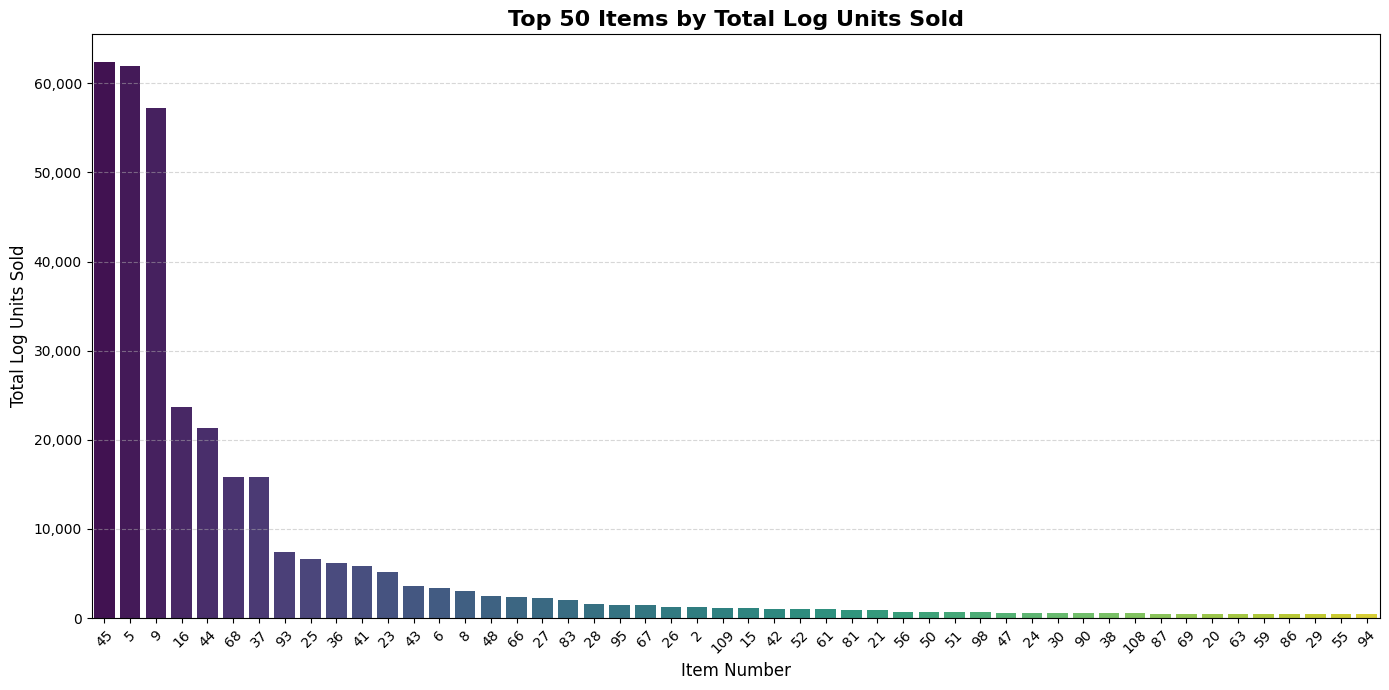

In [60]:
plot_top_items_by_units(df_weather_key_store_merged, top_n = 50)

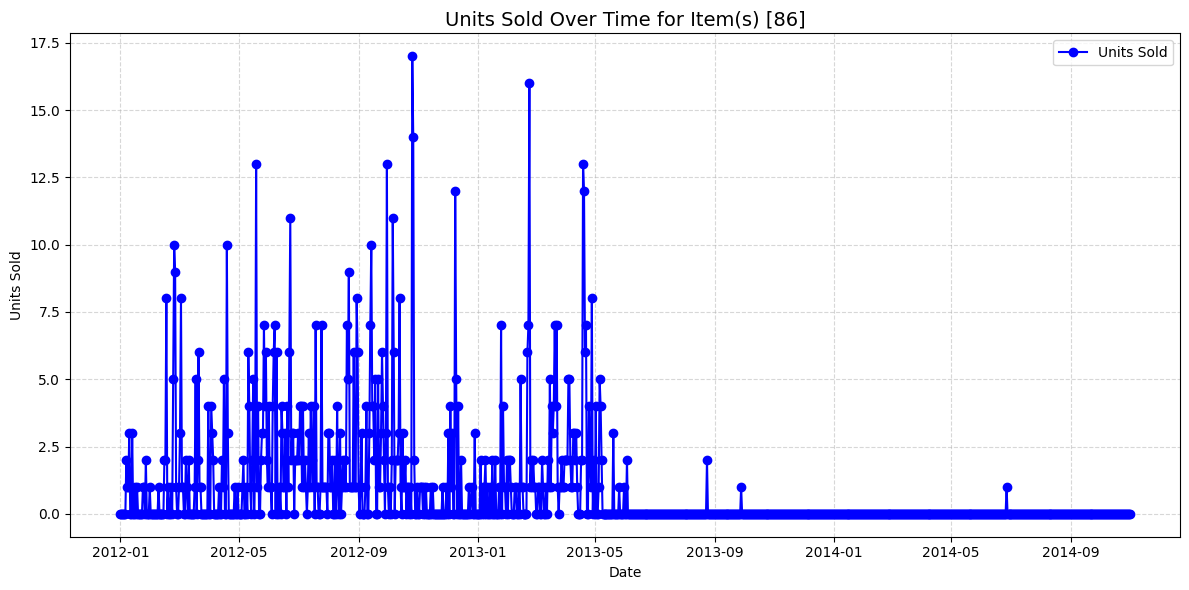

Tổng units bán ra cho item(s) [86]: 877.0


In [61]:
plot_units_for_item(df_sales, item_nbr=86)

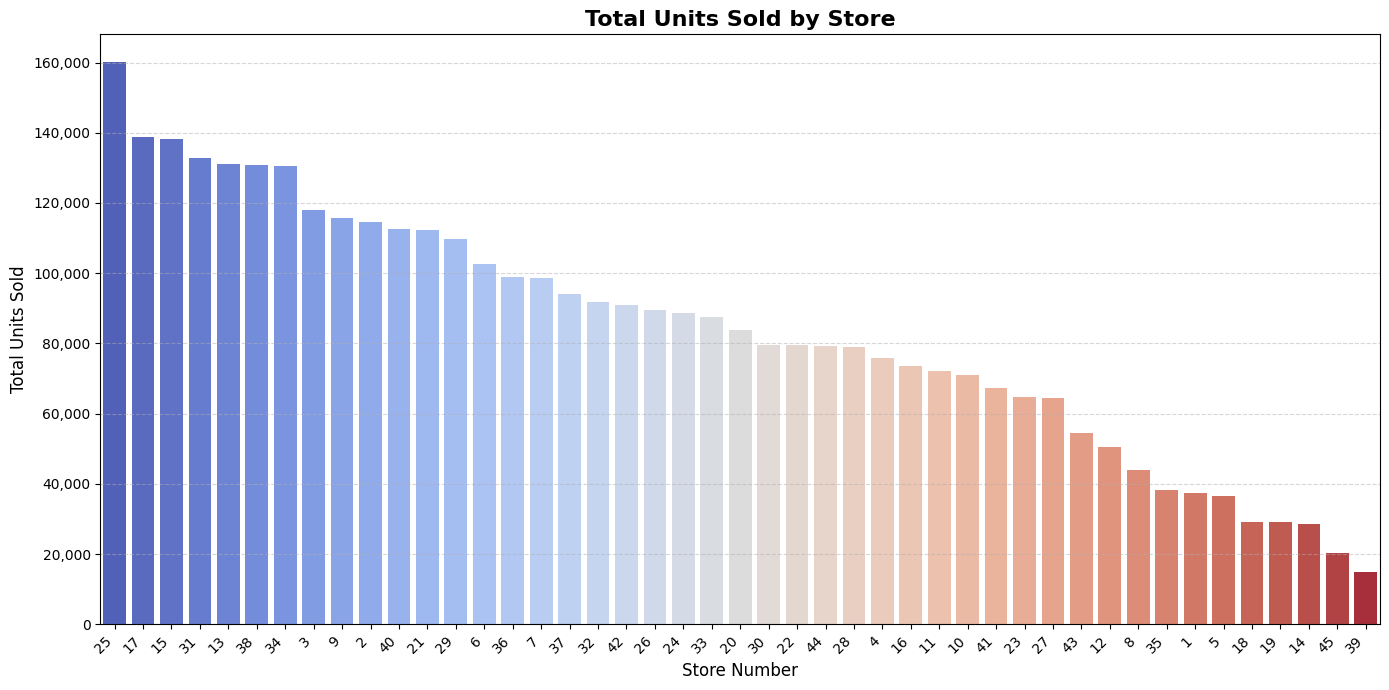

=== Top 5 Stores by Sales ===
  store_nbr          units
0        25  160038.666520
1        17  138778.406329
2        15  138168.848707
3        31  132793.879820
4        13  131097.027059

=== Bottom 5 Stores by Sales ===
   store_nbr    units
40        18  29158.0
41        19  29037.0
42        14  28590.0
43        45  20252.0
44        39  14931.0


In [62]:
plot_units_by_store(df_sales)

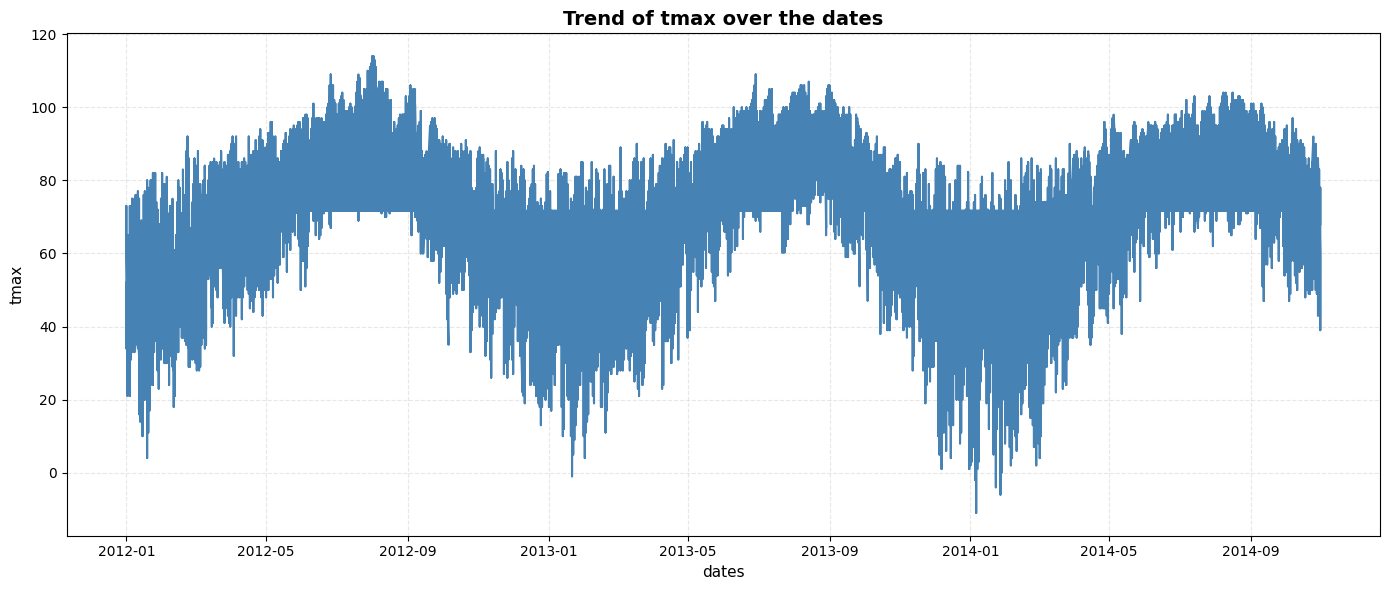

In [63]:
plot_weather_trend(df_weather, weather_col='tmax')

In [64]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, series_name='Series'):
    """
    Thực hiện ADF test để kiểm tra tính stationary.
    """
    result = adfuller(series.dropna())
    
    print(f'\n=== ADF Test for {series_name} ===')
    print(f'Test Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] < 0.05:
        print(f'✅ Kết luận: {series_name} là STATIONARY (p < 0.05)')
    else:
        print(f'❌ Kết luận: {series_name} là NON-STATIONARY (p ≥ 0.05)')
        print(f'   → Cần differencing hoặc detrending trước khi dùng ARIMA.')

In [65]:
test_stationarity(df_weather['tmax'], 'Temperature Max')


=== ADF Test for Temperature Max ===
Test Statistic: -3.9056
p-value: 0.0020
Critical Values:
   1%: -3.4305
   5%: -2.8616
   10%: -2.5668
✅ Kết luận: Temperature Max là STATIONARY (p < 0.05)


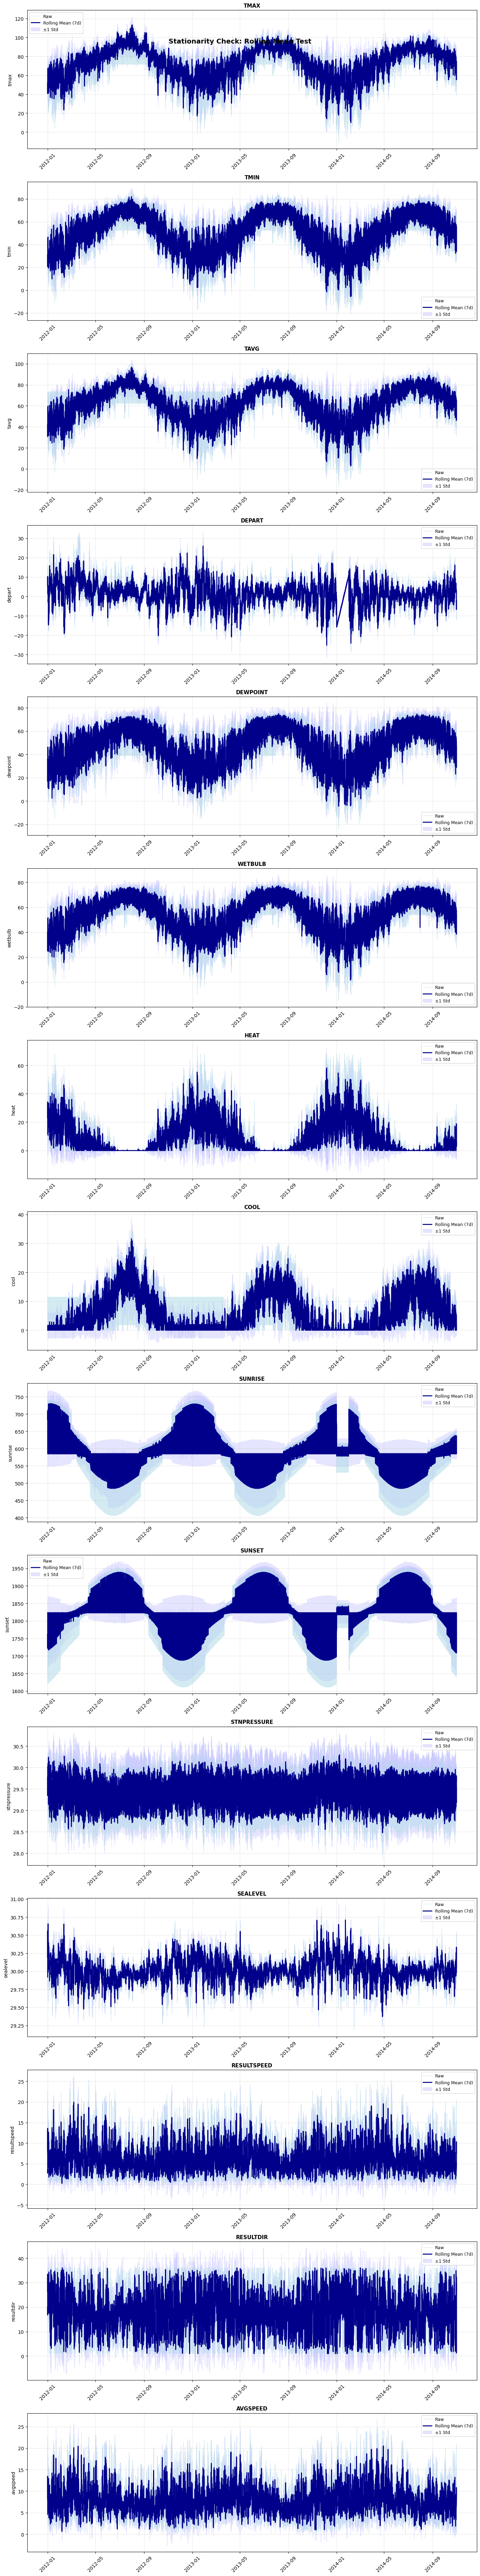


AUGMENTED DICKEY-FULLER (ADF) TEST RESULTS

TMAX: ✅ STATIONARY (p-value = 0.0060)
  Test Stat: -3.5884 | Critical (5%): -2.8616

TMIN: ✅ STATIONARY (p-value = 0.0271)
  Test Stat: -3.0920 | Critical (5%): -2.8616

TAVG: ✅ STATIONARY (p-value = 0.0396)
  Test Stat: -2.9526 | Critical (5%): -2.8616

DEPART: ✅ STATIONARY (p-value = 0.0000)
  Test Stat: -9.7687 | Critical (5%): -2.8616

DEWPOINT: ✅ STATIONARY (p-value = 0.0026)
  Test Stat: -3.8347 | Critical (5%): -2.8616

WETBULB: ✅ STATIONARY (p-value = 0.0132)
  Test Stat: -3.3394 | Critical (5%): -2.8616

HEAT: ✅ STATIONARY (p-value = 0.0054)
  Test Stat: -3.6188 | Critical (5%): -2.8616

COOL: ✅ STATIONARY (p-value = 0.0160)
  Test Stat: -3.2747 | Critical (5%): -2.8616

SUNRISE: ❌ NON-STATIONARY (p-value = 0.3805)
  Test Stat: -1.7999 | Critical (5%): -2.8616

SUNSET: ❌ NON-STATIONARY (p-value = 0.7005)
  Test Stat: -1.1360 | Critical (5%): -2.8616

STNPRESSURE: ✅ STATIONARY (p-value = 0.0000)
  Test Stat: -10.5111 | Critical (5%):

In [66]:
weather_cols = [
    'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 
    'heat', 'cool', 'sunrise', 'sunset', 'stnpressure', 
    'sealevel', 'resultspeed', 'resultdir', 'avgspeed'
]

plot_rolling_mean_stationarity(df_weather, weather_cols=weather_cols)